# RETENTION CURVES FORMULATION 

In this Jupyter Notebook, we derive and implement the constitutive equations that define soil-water retention curve models, specifically focusing on the formulation by [van Genuchten (1980)](https://www.researchgate.net/publication/250125437_A_Closed-form_Equation_for_Predicting_the_Hydraulic_Conductivity_of_Unsaturated_Soils1).

Finally, an interactive example will be presented to facilitate comprehension of the parameters, how they influence the shape of the retention curve, and how they depend on the nature of the soil.


<br>

### Water content, $\Theta$:
 - **Dimensionless water content**

$$ \Theta = {\theta - \theta_{r} \over \theta_{s} - \theta_{r}}$$

where,

$\theta$ soil-water content (t, in the code)

$\theta_{s}$ satured values of the soil-water content (ts, in the code) 

$\theta_{r}$ residual values of the soil-water content (tr, in the code)

<br>

 - **Dimensionless water content related to the pressure head**

$$ \Theta = \left[{1 \over 1 + (\alpha h)^{n}}\right] $$

where,

$h$ pressure head (h in the code), and is understood to be positive

$\alpha$ is related to the inverse of the air entry suction (a in the code)

$n$ is a mesure of the pore-size distribution (n in the code)

<br>

 - **By substituting the first equation into the second, we can derive the retention curve as**

$$ \theta = \theta_{r} + {(\theta_{s} - \theta_{r}) \over \left[1 + (\alpha h)^{n}\right]^{m}}, \space\space\space\space m = 1 - 1/n$$

where,

$m$ is defined as $1 - (1/n)$ (m in the code)

<br>

### Relative Hydraulic Conductivity, $K_{r}$:
 - **Relative Hydraulic Conductivity expressed in terms of the dimensionless water content**

$$ K_{r}(h) = { \{ 1 - (\alpha h)^{n-1} \space \left[ 1 + (\alpha h)^{n} \right]^{-m} \}^{2} \over  \left[1 + (\alpha h)^{n}\right]^{m/2}}, \space\space\space\space m = 1 - 1/n $$

<br>

 - **Relative Hydraulic Conductivity expressed in terms of the dimensionless pressure head**

$$ K_{r}(\Theta) = \Theta^{1/2} \left[1 - \left(1 - \Theta^{1/m}\right)^{m} \right]^{2}, \space\space\space\space m = 1 - 1/n \space\space\space \& \space\space\space 0 \gt m \gt 1$$

<br>

### Diffusivity, $D$:

$$ D(\Theta) = {(1 - m)K_s  \over \alpha m (\theta_{s} - \theta_{r})} \Theta^{1/2 - 1/m} \left[\left( 1 - \Theta^{1/m} \right)^{-m} + \left( 1 - \Theta^{1/m} \right)^{m} - 2 \right] $$

where,

$K_{s}$ is the hydraulic conductivity at saturation (= $K/K_{r}$)

<br>
<br>
<br>

### Coding the equations from van Genuchten, 1980

#### Importing the needed libraries

In [1]:
#-- Check and install required packages if not already installed --#
import sys
import subprocess

def if_require(package):
    try:
        __import__(package)
    except ImportError:
        print(f"{package} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        
#-- Install packages only if they aren't already installed --#
if_require("ipywidgets")

#-- Import the rest of libraries --#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import warnings
warnings.filterwarnings("ignore")

#### Coding the equations as functions

In [2]:
def m_val(n):
    """Function that returns the value of "m"

    Parameters
    ----------
    n : float
        value of "n"

    Returns
    -------
    float
        value of "m"
    """
    
    m = 1 - (1/n)

    return m


def dimensionless_water_content(t, tr, ts):
    """Function that calculates the dimensionless water content. 
    
    Based on van Genuchten, 1980 (Eq. 2) 

    Parameters
    ----------
    t : float
        soil-water content
    tr : float
        residual values of soil-water content
    ts : float
        saturated values of soil-water content

    Returns
    -------
    float
        dimensionless water content
    """
    
    T_dim = (t - tr)/(ts - tr)      

    return T_dim


def water_content(alpha, h, n):  
    """Function that calculates the water content. 
    
    Based on van Genuchten, 1980 (Eq. 3)

    Parameters
    ----------
    alpha : float
        alpha parameter
    h : float
        head pressure (positive)
    n : float
        n parameter

    Returns
    -------
    float
        water content
    """
    
    T = ((1 + (alpha*h)**(n)))**(-(m_val(n)))  

    return T


def soil_water_content(tr, ts, alpha, h, n):
    """Function that calculates the soil-water content.
    
    Based on van Genuchten, 1980 (Eq. 21)

    Parameters
    ----------
    tr : float
        residual values of soil-water content
    ts : float
        saturated values of soil-water content
    alpha : float
        alpha parameter
    n : float
        n parameter
    
    Returns
    -------
    float
        soil-water content
    """

    t = tr + ((ts - tr) / ((1 + (alpha*h)**(n))**m_val(n)))   

    return t
    

def relative_hydraulic_conductivity(alpha, n, h, T):
    """Function that calculates the relative hydraulic conductivity. 

    Based on van Genuchten, 1980 (Eq. 8 and 9).

    Parameters
    ----------
    alpha : float
        alpha parameter
    n : float
        n parameter
    h : float 
        head pressure (positive)
    T : float
        water content

    Returns
    -------
    T: float
        _description_
    Kr_T: float
        relative hydraulic conductivity expressed in terms of the dimensionless water content
    Kr_h: float
        relative hydraulic conductivity expressed in terms of the head pressure   

    Raises
    ------
    ValueError
        If m value is not between 0 and 1
    """
    
    # Check that m_val(n) is within the expected range
    if not (0 < m_val(n) < 1):
        raise ValueError("Parameter 'm' out of range: must be between 0 and 1")

    #-- Relative hydraulic conductivity expressed in terms of the water content
    Y = (1 - T**(1 / m_val(n)))**m_val(n)
    Kr_T = T**0.5 * (1 - Y)**2                     
    
    #-- Relative hydraulic conductivity expressed in terms of the pressure head
    I = (1 - alpha * h)
    U = I**(n - 1)
    P = (1 + (alpha * h)**n)**(m_val(n) / 2)
    
    if I > 0:
        Kr_h = ((U * T)**2) / P 
    else:
        Kr_h = np.nan                        
    
    return Kr_T, Kr_h


def soil_water_diffusivity(Ks, n, ts, tr, T):
    """Function that calculates the soil water diffusivity.

    Based on van Genuchten, 1980 (Eq. 11).

    Parameters
    ----------
    Ks : float
        hydraulic conductivity at saturation
    n  : float
        n parameter
    ts : float
        satured soil-water content
    tr : float
        residual soil-water content
    T : float
        dimensionless water content

    Returns
    -------
    D_T : float
        soil water diffusivity
    """
    
    I = ((1 - m_val(n))*Ks) / (alpha*m_val(n)*(ts - tr))
    L = T**(0.5 - (1/m_val(n)))
    Y = (1 - T**(1 / m_val(n)))**m_val(n)
    P = ((1/Y) + (Y) - 2)
    
    D_T = I * L * P                                        

    return D_T


### Example from [van Genuchten (1980)](https://www.researchgate.net/publication/250125437_A_Closed-form_Equation_for_Predicting_the_Hydraulic_Conductivity_of_Unsaturated_Soils1)

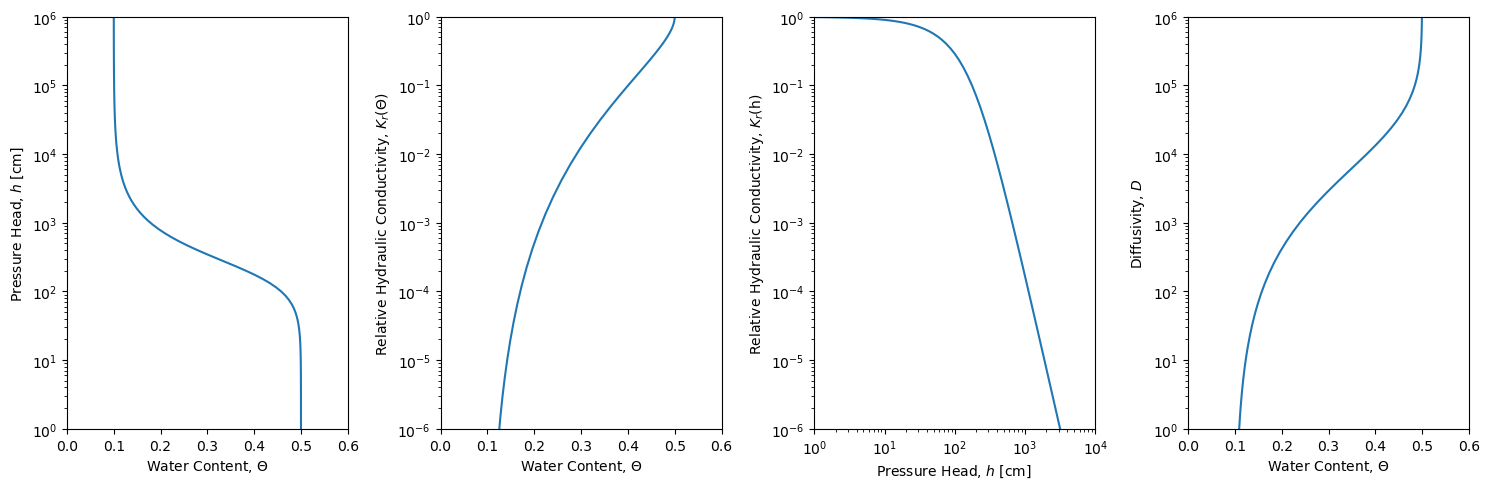

In [3]:
# Given parameters:
tr = 0.10       # residual water content
ts = 0.50       # saturated water content
alpha = 0.005   # l/cm
n = 2.0         # shape parameter
Ks = 100        # cm/day

#-- Generate pressure head values:
h_values = np.logspace(0, 6, 100)  

#-- Calculate water content values
t_values = [soil_water_content(tr, ts, alpha, h, n) for h in h_values]
T_values = [water_content(alpha, h, n) for h in h_values]

#-- Calculate dimensionless water content and relative hydraulic conductivity
Kr_T, Kr_h = zip(*[relative_hydraulic_conductivity(alpha, n, h, T) for h, T in zip(h_values, T_values)])
Kr_T = list(Kr_T)  
Kr_h = list(Kr_h) 

#-- Calculate the soil-water diffusivity
D_T = [soil_water_diffusivity(Ks, n, ts, tr, T) for T in T_values]

#-- Plot the 3 figures
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

# ax1: Water content vs. Pressure head
ax1.plot(t_values, np.abs(h_values))
ax1.set_xlim(0, 0.6)
ax1.set_ylim(np.abs(h_values[0]), np.abs(h_values[-1]))
ax1.set_yscale('log')
ax1.set_xlabel(r'Water Content, $\Theta$')
ax1.set_ylabel(r'Pressure Head, $h$ [cm]')

# ax2: Water content vs. Relative Hydraulic Conductivity expressed in terms of water content
ax2.plot(t_values, Kr_T) 
ax2.set_yscale('log')
ax2.set_ylim(0.000001, 1)
ax2.set_xlim(0, 0.6)
ax2.set_xlabel(r'Water Content, $\Theta$')
ax2.set_ylabel(r'Relative Hydraulic Conductivity, $K_{r}$($\Theta$)')

# ax2: Water content vs. Relative Hydraulic Conductivity expressed in terms of pressure head
ax3.plot(np.abs(h_values), Kr_T) 
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim(1, 10000)
ax3.set_ylim(0.000001, 1)
ax3.set_xlabel('Pressure Head, $h$ [cm] ')
ax3.set_ylabel(r'Relative Hydraulic Conductivity, $K_{r}($h$)$')

# ax4: Water content vs. Diffusivity
ax4.plot(t_values, D_T)
ax4.set_xlim(0, 0.6)
ax4.set_yscale('log')
ax4.set_ylim(1, 1000000)
ax4.set_xlabel(r'Water Content, $\Theta$')
ax4.set_ylabel(r'Diffusivity, $D$')

plt.tight_layout()
plt.show()


## Retention Curves, an example

This section presents the suction pressure and water content data for two soil types: sand and silt. 

<br>
<br>

\begin{array}{|l l|l l|}
\hline
\text{$\quad\quad\quad$ Sand Soil} & \text{} & \text{$\quad\quad\quad$ Silt Soil} & \text{}\\
\hline
\text{|$\psi$| [hPa]} & \text{$\theta$} & \text{|$\psi$| [hPa]} & \text{$\theta$}\\
\hline
\text{1}        & \text{0.368}      & \text{1}          & \text{0.422}\\
\hline
\text{2}        & \text{0.365}      & \text{2}          & \text{0.422}\\
\hline
\text{3}        & \text{0.358}      & \text{6}          & \text{0.421}\\
\hline
\text{4}        & \text{0.348}      & \text{25}         & \text{0.417}\\
\hline
\text{8}        & \text{0.321}      & \text{49}         & \text{0.412}\\
\hline
\text{12}       & \text{0.293}      & \text{118}        & \text{0.395}\\
\hline
\text{17}       & \text{0.267}      & \text{235}        & \text{0.366}\\
\hline
\text{23}       & \text{0.240}      & \text{354}        & \text{0.342}\\
\hline
\text{32}       & \text{0.213}      & \text{488}        & \text{0.319}\\
\hline
\text{46}       & \text{0.185}      & \text{765}        & \text{0.285}\\
\hline
\text{65}       & \text{0.160}      & \text{1033}       & \text{0.260}\\
\hline
\text{98}       & \text{0.137}      & \text{1456}       & \text{0.236}\\
\hline
\text{148}      & \text{0.119}      & \text{2656}       & \text{0.195}\\
\hline
\text{328}      & \text{0.090}      & \text{4351}       & \text{0.167}\\
\hline
\text{726}      & \text{0.074}      & \text{6830}       & \text{0.143}\\
\hline
\text{1217}     & \text{0.065}      & \text{13582}      & \text{0.113}\\
\hline
\text{2175}     & \text{0.059}      & \text{26438}      & \text{0.089}\\
\hline
\text{4330}     & \text{0.054}      & \text{45248}      & \text{0.074}\\
\hline
\text{7576}     & \text{0.051}      & \text{98112}      & \text{0.057}\\
\hline
\text{16796}    & \text{0.048}      & \text{199482}     & \text{0.045}\\
\hline
\text{41464}    & \text{0.046}      & \text{396999}     & \text{0.035}\\
\hline
\text{95973}    & \text{0.045}      & \text{958958}     & \text{0.026}\\
\hline
\end{array}

<br>
<br>

The tasks are as follows:

**a)** For each soil type, determine the best-fitting parameters.

In [4]:
#-----------------------------------#
# From the table to a dataframe     #
#-----------------------------------#

#-- Sand Soil --#
sandSoil = pd.DataFrame()
sandSoil["Suction Pressure [hPa]"] = [1, 2, 3, 4, 8, 12, 17, 23, 32, 46, 65, 98, 148, 328, 726, 1217, 
                                      2175, 4330, 7576, 16796, 41464, 95973]
sandSoil["Water Content"] = [0.368, 0.365, 0.358, 0.348, 0.321, 0.293, 0.267, 0.240, 0.213, 0.185, 0.160, 
                             0.137, 0.119, 0.090, 0.074, 0.065, 0.059, 0.054, 0.051, 0.048, 0.046, 0.045]

#-- Silt Soil --#
siltSoil = pd.DataFrame()
siltSoil["Suction Pressure [hPa]"] = [1, 2, 6, 25, 49, 118, 235, 354, 488, 765, 1033, 1456, 2656, 4351, 
                                      6830, 13582, 26438, 45248, 98112, 199482, 396999, 958958]
siltSoil["Water Content"] = [0.422, 0.422, 0.421, 0.417, 0.412, 0.395, 0.366, 0.342, 0.319, 0.285, 0.260, 
                             0.236, 0.195, 0.167, 0.143, 0.113, 0.089, 0.074, 0.057, 0.045, 0.035, 0.026]


#-----------------------------------#
# Resolution and plot               # 
#-----------------------------------#

def find_parameters(tr_sand, ts_sand, alpha_sand, n_sand,
                    tr_silt, ts_silt, alpha_silt, n_silt):
    """Calculates, fits and visualizes the soil-water retention curve for sand and silt soils using 
    the van Genuchten model.

    Parameters
    ----------
    tr_sand : float
        residual soil-water content of the sand soil
    ts_sand : float
        satured soil-water content of the sand soil
    alpha_sand : float
        alpha parameter for the sand soil
    n_sand : float
        n parameter for the sand soil
    tr_silt : float
        residual soil-water content of the silt soil
    ts_silt : float
        satured soil-water content of the silt soil
    alpha_silt : float
        alpha parameter for the silt soil
    n_silt : float
        n parameter for the silt soil 
    """
    
    #-- Generating the range of head values
    h_values = np.logspace(0, 6, 100)
      
    #-- Calculating the soil-water content for both soild
    t_sand = [soil_water_content(tr_sand, ts_sand, alpha_sand, h, n_sand) for h in h_values]
    t_silt = [soil_water_content(tr_silt, ts_silt, alpha_silt, h, n_silt) for h in h_values]
    
    #-- Plotting the results
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(sandSoil["Water Content"], sandSoil["Suction Pressure [hPa]"], 'o', mfc='none', 
            c="green", label="Observations Sand Soil")
    ax.plot(siltSoil["Water Content"], siltSoil["Suction Pressure [hPa]"], 'o', mfc='none',
            c="blue", label="Observations Silt Soil")   
    ax.plot(t_sand, h_values, 
            c="green", label="Model Sand Soil")
    ax.plot(t_silt, h_values, 
            c="blue", label="Model Silt Soil")
    ax.set_xlim(0, 0.5)
    ax.set_ylim(1, 1000000)
    ax.set_yscale('log')
    ax.set_xlabel(r'Water Content, $\Theta$')
    ax.set_ylabel('Suction Pressure [hPa]')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    plt.show()

sand_sliders = [
    widgets.FloatSlider(value=0.2, min=0, max=0.5, step=0.001, readout_format='.3f', description='θr sand'), 
    widgets.FloatSlider(value=0.2, min=0, max=0.5, step=0.001, readout_format='.3f', description='θs sand'),
    widgets.FloatSlider(value=0.05, min=0, max=0.1, step=0.0001, readout_format='.4f', description='α sand'), 
    widgets.FloatSlider(value=2.5, min=0, max=5, step=0.05, readout_format='.2f', description='n sand')
]

silt_sliders = [
    widgets.FloatSlider(value=0.3, min=0, max=0.5, step=0.001, readout_format='.3f', description='θr silt'), 
    widgets.FloatSlider(value=0.3, min=0, max=0.5, step=0.001, readout_format='.3f', description='θs silt'),
    widgets.FloatSlider(value=0.05, min=0, max=0.1, step=0.0001, readout_format='.4f', description='α silt'), 
    widgets.FloatSlider(value=2.5, min=0, max=5, step=0.05, readout_format='.2f', description='n silt')
]

ui = widgets.HBox([widgets.VBox(sand_sliders), widgets.VBox(silt_sliders)])

out = widgets.interactive_output(find_parameters, {
    'tr_sand': sand_sliders[0],
    'ts_sand': sand_sliders[1],
    'alpha_sand': sand_sliders[2],
    'n_sand': sand_sliders[3],
    'tr_silt': silt_sliders[0],
    'ts_silt': silt_sliders[1],
    'alpha_silt': silt_sliders[2],
    'n_silt': silt_sliders[3]
})

display(ui, out)

Output()

**b)** Discuss how these parameters and the resulting retention curves reflect the intrinsic characteristics of each soil type.

—Write here the answer of the question— 